<a href="https://colab.research.google.com/github/stevec12/PyTorch-Learning/blob/main/MNIST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [56]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [57]:
# Uses GPU if available to speed up PyTorch operations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# For Img Resolution, 14 or 28, set lower for testing
img_size = 14

In [97]:
class MNIST(torch.utils.data.Dataset):
  def __init__(self, n : int, img_size: int, train=True) -> None:
    self.img_size = img_size
    self.n = n
    full_dataset = torchvision.datasets.MNIST('./data/', train=train, download = True,
                           transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((img_size,img_size)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Lambda((lambda x: torch.flatten(x)))
                           ])) 
    dataset_n = torch.utils.data.Subset(full_dataset, range(self.n))
    self.x = dataset_n

  def __len__(self):
    return len(self.x)
  
  def __getitem__(self,idx):
    ''' 
    __getitem__(index) returns image and class for a sample
    '''
    x = self.x[idx][0]
    t = self.x[idx][1]
    return x, t


In [59]:
ds = MNIST(1024,14)

## Create some plotting tools

In [68]:
def draw(i: torch.Tensor, img_size: int = 28):
  '''
  i=[x,t] s.t.
  draw(i, img_size) draws image for x, uses t as label
  '''
  x = i[0]
  t = i[1]
  plt.style.use('_mpl-gallery-nogrid')
  fig, ax = plt.subplots()
  formattedx = x.reshape((img_size,img_size)).detach().numpy()
  ax.imshow(formattedx,cmap='gray')
  plt.title(f'Class {t}')
  plt.show()

def drawIndices(idxs: list[int], fig: plt.figure, ds: MNIST, img_size: int) -> None:
  '''
  drawIndices(i,figure,ds) draws the given indices from ds, 
    using figure object. Plots axes in most "square" form.
  '''

  total_len = len(idxs)
  ncols = int(np.floor(np.sqrt(total_len))) # Prefer less cols
  nrows = int( np.ceil(np.sqrt(total_len)) )
  if ncols*nrows < total_len:
    nrows += 1
  

  axes = {}
  for i in range(total_len):
    axes[i] = fig.add_subplot(nrows,ncols,i+1)
  
  fig.subplots_adjust(hspace = .6)
  for i in range(total_len):
    x = ds[idxs[i]][0]
    t = ds[idxs[i]][1]

    formatted_x = x.reshape((img_size,img_size)).detach().numpy() 
    ax = axes[i]
    ax.imshow(formatted_x, cmap='gray')

    ax.set_title(f'Class {t}', size=8)
    ax.axis('off')
    
  plt.show()

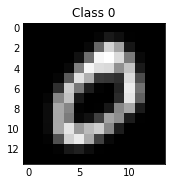

In [69]:
draw(ds[1],14)

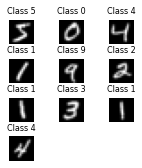

In [70]:
# Print first 10 images
fig = plt.figure()
drawIndices(range(0,10),fig, ds, img_size)

## Dataloaders

In [71]:
# Train batches
batch_size_train = 128
train_dl = torch.utils.data.DataLoader(ds, 
                                       batch_size = batch_size_train, shuffle=True)
# Full dataset
full_dl = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

## Create Neural Network Model
Simple linear model

In [93]:
class MyNNet(nn.Module):
  '''
  Desc
  '''
  def __init__(self, input_size, output_size, loss_fcn=None):
    super().__init__()
    self.losses = []
    self.loss_fcn = loss_fcn

    self.net = nn.Sequential(nn.Linear(input_size, input_size),
                                   nn.ReLU(),
                                   nn.Linear(input_size, int(input_size/2)),
                                   nn.ReLU(),
                                   nn.Linear(int(input_size/2),input_size),
                                   nn.ReLU(),
                                   nn.Linear(input_size,output_size))
    

  def forward(self, x):
    return self.net(x)

  def learn(self, dl, epochs=1000, lr=0.01, plot=True):
    optim = torch.optim.SGD(self.parameters(), lr=lr, momentum=0.5)
    for epoch in tqdm(range(epochs)):
      total_loss = 0.
      for x,t in dl:
        # GPU Support for x
        x.to(device)   
        # One-hot t
        t = torch.nn.functional.one_hot(
            t.to(torch.long),num_classes=10).squeeze()
        y = self(x)

        ### Debug Code Begins
        print(f'y shape: {y.shape}, t shape: {t.shape}')
        print(f'y:{y}, t:{t}')
        ### Debug Code Ends
        
        loss = self.loss_fcn(y,t.float())
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.item()*len(t)
      self.losses.append(total_loss/len(dl))
    if plot:
      plt.figure(figsize=(5,5))
      plt.plot(self.losses);
      plt.yscale('log')


## Model Setup and Training

In [94]:
# Model Setup
in_size = len(next(iter(ds))[0])
out_size = len(set(next(iter(full_dl))[1].detach().numpy()))
loss = nn.CrossEntropyLoss()
nnet1 = MyNNet(input_size=in_size, 
               output_size=out_size, loss_fcn=loss)

In [ ]:
# Train Model
nnet1.learn(train_dl, epochs=1000, lr=0.01, plot=True)

In [96]:
# Save Trained Model 
torch.save(nnet1.to(device), 'NNet1.pt')

## Model testing

In [116]:
# Get testing dataloader
test_ds = MNIST(1024, 14, train = False)
# Calculate Test Error
correct = 0
for x,t in test_ds:
  pred = np.argmax(nnet1(x).detach().numpy())
  if (pred == t):
    correct += 1
accuracy = correct/1024
print(f'Model has {accuracy*100.}% accuracy WRT Test Data.')

Model has 82.91015625% accuracy WRT Test Data.
